In [97]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt

In [98]:
df = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed.csv')
df.head()

,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0.071562,0.370295,-0.264868,-0.678432,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,0.298465,-0.364226,-0.033312,-0.253081,-0.144348,-1.606014,0.137217,-0.243548,-0.16588,0.479517
1,-0.870615,0.370295,0.008674,-0.678432,-0.497470,0.651974,-2.322601,0.312313,-0.190100,-0.038110,...,-0.749164,-0.364226,-0.033312,-0.253081,-0.144348,-0.495788,-0.618051,-0.243548,-0.16588,0.091359
2,0.071562,0.370295,0.401148,1.091978,-0.301189,0.435239,0.227107,0.312313,1.232693,0.707029,...,-0.027846,-0.364226,-0.033312,-0.253081,-0.144348,0.984513,0.137217,-0.243548,-0.16588,0.695160
3,0.071562,0.370295,1.117115,1.091978,-0.497470,2.401165,0.227107,0.312313,1.232693,1.452168,...,0.693472,-0.364226,-0.033312,-0.253081,-0.144348,2.094739,0.137217,-0.243548,-0.16588,1.076129
4,-0.870615,0.370295,0.123800,-0.678432,-0.301189,0.930463,0.227107,0.312313,-0.190100,1.452168,...,0.229768,-0.364226,-0.033312,-0.253081,-0.144348,0.614438,-0.618051,-0.243548,-0.16588,1.895573


In [99]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

for col in X.select_dtypes(include="object").columns:
    X[col] = X[col].astype("category")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Feature Selection

### 2.1 Basic selection

In [100]:
corr_matr = df.corr().abs()
upper_tri = corr_matr.where(np.triu(np.ones(corr_matr.shape), k=1).astype(bool))

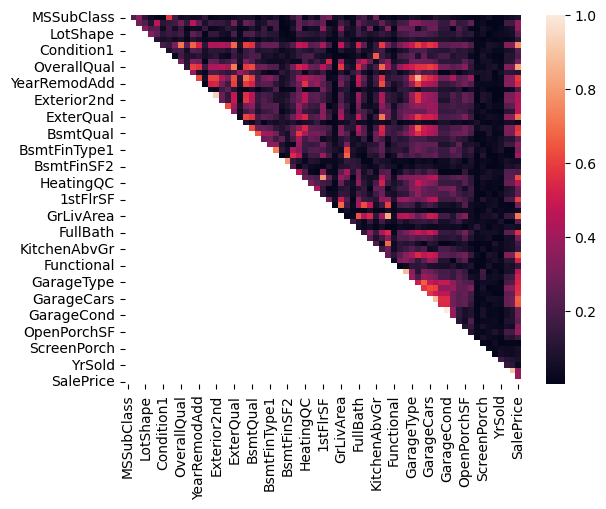

In [101]:
import seaborn as sns

plt.figure()
sns.heatmap(upper_tri)
plt.show()

In [102]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

df1 = df.drop(to_drop, axis=1)

['Exterior2nd', 'GarageCond']


### 2.2 Shap on XGBoost

In [103]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [104]:
import xgboost as xgb

base_model_xgb = xgb.XGBRegressor()

scores_xgb = cross_val_score(base_model_xgb, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb = np.sqrt(-scores_xgb)

print(f'Mean RMSE: {rmse_xgb.mean()}')

Mean RMSE: 0.32108733736477085


In [105]:
import shap

base_model.fit(X, y)

explainer = shap.TreeExplainer(base_model)
shap_values_xgb = explainer.shap_values(X)

mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
importance_df_xgb = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_xgb
}).sort_values('importance', ascending=False)

importance_df_xgb.head(20)

,feature,importance
9,OverallQual,0.395564
36,GrLivArea,0.185727
5,Neighborhood,0.106541
29,TotalBsmtSF,0.058141
25,BsmtFinSF1,0.051472
51,GarageCars,0.039220
33,1stFlrSF,0.037795
10,OverallCond,0.034810
43,KitchenQual,0.033266
2,LotArea,0.032202


In [106]:
most_rel_feat_xgb = importance_df_xgb['feature'].values[:20].tolist()
print(most_rel_feat_xgb)

['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageCars', '1stFlrSF', 'OverallCond', 'KitchenQual', 'LotArea', 'GarageArea', 'BsmtFinType1', 'YearBuilt', 'FireplaceQu', 'BsmtFullBath', 'GarageType', 'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'ExterQual']


Mean RMSE: 0.3237777263349414


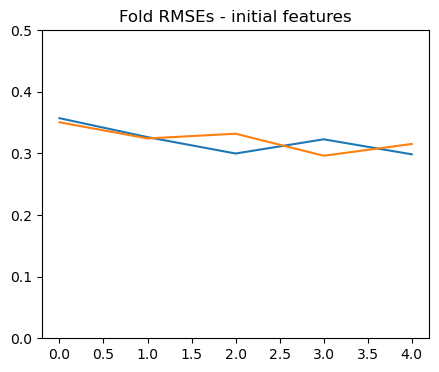

In [107]:
import xgboost as xgb

model = xgb.XGBRegressor()

scores_xgb_2 = cross_val_score(model, X[most_rel_feat_xgb], y, cv=kf, scoring='neg_mean_squared_error')
rmse_xgb_2 = np.sqrt(-scores_xgb_2)

print(f'Mean RMSE: {rmse_xgb_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_2)
plt.show()

### 2.3 Shap on SVR

In [108]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm = cross_val_score(base_model_svr, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm = np.sqrt(-scores_svm)

print(f'Mean RMSE: {rmse_svm.mean()}')

Mean RMSE: 0.3324897478319556


In [109]:
import shap

base_model_svr.fit(X,y)
X_summary = shap.kmeans(X_train, 10)

explainer = shap.KernelExplainer(base_model_svr.predict, X_summary)

shap_values_svm = explainer.shap_values(X_test[:100])

mean_shap_svm = np.abs(shap_values_svm).mean(axis=0)
importance_df_svm = pd.DataFrame({
    "feature": X.columns.values,
    "importance": mean_shap_svm
}).sort_values('importance', ascending=False)

importance_df_svm.head(20)

100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


,feature,importance
36,GrLivArea,0.123045
9,OverallQual,0.094886
34,2ndFlrSF,0.074338
33,1stFlrSF,0.067188
29,TotalBsmtSF,0.059907
5,Neighborhood,0.043817
25,BsmtFinSF1,0.035700
10,OverallCond,0.035052
1,MSZoning,0.028004
51,GarageCars,0.027942


In [110]:
most_rel_feat_svm = importance_df_svm['feature'].values[:20].tolist()
print(most_rel_feat_svm)

['GrLivArea', 'OverallQual', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF', 'Neighborhood', 'BsmtFinSF1', 'OverallCond', 'MSZoning', 'GarageCars', 'GarageArea', 'KitchenQual', 'YearBuilt', 'BsmtQual', 'LotArea', 'BsmtFinType1', 'SaleCondition', 'FullBath', 'YearRemodAdd', 'GarageFinish']


Mean RMSE: 0.3227997349249253


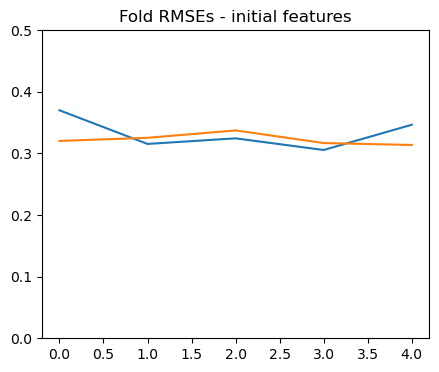

In [111]:
from sklearn.svm import SVR

base_model_svr = SVR()

scores_svm_2 = cross_val_score(base_model_svr, X[most_rel_feat_svm], y, cv=kf, scoring='neg_mean_squared_error')
rmse_svm_2 = np.sqrt(-scores_svm_2)

print(f'Mean RMSE: {rmse_svm_2.mean()}')

plt.figure(figsize=(5,4))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)
plt.plot(rmse_svm)
plt.plot(rmse_svm_2)
plt.show()

### 2.4 Cumulative importance

In [112]:
importance_df = pd.DataFrame({
    'feature': importance_df_svm['feature'],
    'importance_svm': importance_df_svm['importance'],
    'importance_xgb': importance_df_xgb['importance']
})

importance_df['rank_svm'] = importance_df['importance_svm'].rank(ascending=False, method='min')
importance_df['rank_xgb'] = importance_df['importance_xgb'].rank(ascending=False, method='min')

importance_df['rank_sum'] = importance_df['rank_svm'] + importance_df['rank_xgb']
importance_df = importance_df.sort_values('rank_sum', ascending=True)

importance_df.head(20)

,feature,importance_svm,importance_xgb,rank_svm,rank_xgb,rank_sum
9,OverallQual,0.094886,0.395564,2.0,1.0,3.0
36,GrLivArea,0.123045,0.185727,1.0,2.0,3.0
5,Neighborhood,0.043817,0.106541,6.0,3.0,9.0
29,TotalBsmtSF,0.059907,0.058141,5.0,4.0,9.0
33,1stFlrSF,0.067188,0.037795,4.0,7.0,11.0
25,BsmtFinSF1,0.035700,0.051472,7.0,5.0,12.0
51,GarageCars,0.027942,0.039220,10.0,6.0,16.0
10,OverallCond,0.035052,0.034810,8.0,8.0,16.0
43,KitchenQual,0.019291,0.033266,12.0,9.0,21.0
34,2ndFlrSF,0.074338,0.014521,3.0,19.0,22.0


In [113]:
most_rel_feat = importance_df['feature'].values[:20].tolist()
print(most_rel_feat)

['OverallQual', 'GrLivArea', 'Neighborhood', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'GarageCars', 'OverallCond', 'KitchenQual', '2ndFlrSF', 'GarageArea', 'LotArea', 'YearBuilt', 'BsmtFinType1', 'YearRemodAdd', 'SaleCondition', 'BsmtQual', 'Condition1', 'ExterQual', 'Exterior1st']


Mean RMSE XGB: 0.3244232036461982
Mean RMSE SVM: 0.3253218175799371


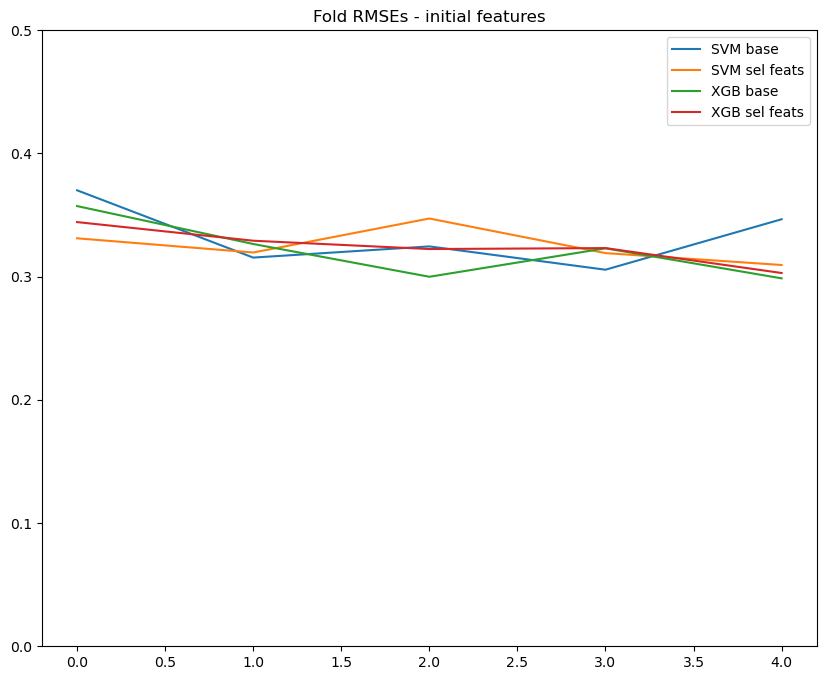

In [114]:
from sklearn.svm import SVR
import xgboost as xgb

base_model_svr = SVR()

scores_xgb_3 = cross_val_score(base_model_xgb, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')
scores_svm_3 = cross_val_score(base_model_svr, X[most_rel_feat], y, cv=kf, scoring='neg_mean_squared_error')

rmse_xgb_3 = np.sqrt(-scores_xgb_3)
rmse_svm_3 = np.sqrt(-scores_svm_3)

print(f'Mean RMSE XGB: {rmse_xgb_3.mean()}')
print(f'Mean RMSE SVM: {rmse_svm_3.mean()}')

plt.figure(figsize=(10,8))
plt.title('Fold RMSEs - initial features')
plt.ylim(0, 0.5)

plt.plot(rmse_svm)
plt.plot(rmse_svm_3)
plt.plot(rmse_xgb)
plt.plot(rmse_xgb_3)

plt.legend([
    "SVM base",
    "SVM sel feats",
    "XGB base",
    "XGB sel feats"
])

plt.show()

In [115]:
X_sel = X[most_rel_feat]

## 3. Model Optimization

In [116]:
import optuna
from sklearn.model_selection import cross_val_score

from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

def optimization_plots(study):
    fig1 = plot_optimization_history(study)
    fig1.show()

    fig2 = plot_contour(study)
    fig2.show()

    fig3 = plot_rank(study)
    fig3.show()

    fig4 = plot_param_importances(study)
    fig4.show()

In [117]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

### 3.1 XGBoost

In [129]:
import math
import xgboost as xgb

study_name = 'kag1-2-XGB-3'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_xgb(trial):
    num_estimators = trial.suggest_int("num_estimators", 100, 2000, log=True)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 16, log=True)
    
    model = xgb.XGBRegressor(n_estimators=num_estimators, max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1, tree_method="hist", enable_categorical=True)
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", )
    
    return math.sqrt(-scores.mean())

study_xgb = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-20 22:42:28,998] A new study created in RDB with name: kag1-2-XGB-3


In [131]:
study_xgb.optimize(optimize_xgb, n_trials=75)
print(study_xgb.best_trial)

[I 2025-08-20 22:43:14,327] Trial 5 finished with value: 0.3353514295590906 and parameters: {'num_estimators': 168, 'learning_rate': 0.04471972856332986, 'max_depth': 14}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:43:46,717] Trial 6 finished with value: 0.33221879370914176 and parameters: {'num_estimators': 1742, 'learning_rate': 0.006170332976273355, 'max_depth': 9}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:43:50,765] Trial 7 finished with value: 0.36107958026468046 and parameters: {'num_estimators': 122, 'learning_rate': 0.021023395243381728, 'max_depth': 14}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:44:04,173] Trial 8 finished with value: 0.33792740372468494 and parameters: {'num_estimators': 825, 'learning_rate': 0.028521023633557848, 'max_depth': 13}. Best is trial 0 with value: 0.29290315950485213.
[I 2025-08-20 22:44:04,952] Trial 9 finished with value: 0.6141812994257837 and parameters: {'num_estimators':

FrozenTrial(number=63, state=1, values=[0.28554896018260395], datetime_start=datetime.datetime(2025, 8, 20, 22, 51, 10, 498653), datetime_complete=datetime.datetime(2025, 8, 20, 22, 51, 15, 880452), params={'num_estimators': 1445, 'learning_rate': 0.03580237054415945, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_estimators': IntDistribution(high=2000, log=True, low=100, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.005, step=None), 'max_depth': IntDistribution(high=16, log=True, low=2, step=1)}, trial_id=64, value=None)


In [132]:
optimization_plots(study_xgb)

### 3.2 SVR

In [147]:
import math
from sklearn.svm import SVR

study_name = 'kag1-2-SVR-1'
storage_name = "sqlite:///{}.db".format(study_name)

def optimize_svr(trial):
    c = trial.suggest_float("c", 0.1, 100, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    epsilon = trial.suggest_float("epsilon", 0.001, 1, log=True)
    
    model = SVR(kernel=kernel, C=c, gamma=gamma, epsilon=epsilon)
    scores = cross_val_score(model, X_sel, y, cv=kf, scoring="neg_mean_squared_error")
    
    return math.sqrt(-scores.mean())

study_svr = optuna.create_study(study_name=study_name, storage=storage_name, direction='minimize', load_if_exists=True)

[I 2025-08-20 23:07:56,838] A new study created in RDB with name: kag1-2-SVR-1


In [148]:
study_svr.optimize(optimize_svr, n_trials=100)
print(study_svr.best_trial)

[I 2025-08-20 23:07:59,114] Trial 0 finished with value: 68.47714134810758 and parameters: {'c': 2.555783211777136, 'gamma': 0.08455977053821459, 'kernel': 'sigmoid', 'epsilon': 0.023579189294939927}. Best is trial 0 with value: 68.47714134810758.
[I 2025-08-20 23:07:59,300] Trial 1 finished with value: 0.43826354144478774 and parameters: {'c': 24.05441874503355, 'gamma': 0.009657311758417894, 'kernel': 'poly', 'epsilon': 0.04707626723697133}. Best is trial 1 with value: 0.43826354144478774.
[I 2025-08-20 23:07:59,961] Trial 2 finished with value: 0.3320524751518274 and parameters: {'c': 3.835603898021092, 'gamma': 0.5722874616003231, 'kernel': 'linear', 'epsilon': 0.3473960287671192}. Best is trial 2 with value: 0.3320524751518274.
[I 2025-08-20 23:08:00,220] Trial 3 finished with value: 0.47478890717534544 and parameters: {'c': 0.656669123499663, 'gamma': 0.05567640855947798, 'kernel': 'poly', 'epsilon': 0.06137689479262497}. Best is trial 2 with value: 0.3320524751518274.
[I 2025-08

FrozenTrial(number=45, state=1, values=[0.2774922177045317], datetime_start=datetime.datetime(2025, 8, 20, 23, 9, 57, 953105), datetime_complete=datetime.datetime(2025, 8, 20, 23, 9, 58, 316434), params={'c': 31.582433528986833, 'gamma': 0.0018467994145377371, 'kernel': 'rbf', 'epsilon': 0.0017022070261807152}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'c': FloatDistribution(high=100.0, log=True, low=0.1, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.001, step=None), 'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid')), 'epsilon': FloatDistribution(high=1.0, log=True, low=0.001, step=None)}, trial_id=46, value=None)


In [150]:
optimization_plots(study_svr)

## 4. Predictions

In [151]:
X_test = pd.read_csv('house-prices-advanced-regression-techniques/preprocessed_test.csv')
X_test = X_test[most_rel_feat]

for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = X_test[col].astype("category")
    
print(X_test.shape)
X_test.head()

(1459, 20)


,OverallQual,GrLivArea,Neighborhood,TotalBsmtSF,1stFlrSF,BsmtFinSF1,GarageCars,OverallCond,KitchenQual,2ndFlrSF,GarageArea,LotArea,YearBuilt,BsmtFinType1,YearRemodAdd,SaleCondition,BsmtQual,Condition1,ExterQual,Exterior1st
0,-0.783249,-1.238004,-0.599170,-0.371277,-0.680361,0.088294,-1.030622,0.387257,-0.762106,-0.796249,1.274818,0.489633,-0.368222,-0.247683,-1.149202,-0.16588,-0.540577,-2.322601,-0.695257,1.123418
1,-0.038110,-0.300611,-0.599170,0.767502,0.554093,1.166201,-1.030622,0.387257,0.778571,-0.796249,-0.755426,1.118780,-0.468764,0.694158,-1.293726,-0.16588,-0.540577,0.227107,-0.695257,-1.138239
2,-0.783249,0.348853,0.302025,-0.254088,-0.589131,0.853489,0.333130,-0.517033,-0.762106,0.881054,0.070271,1.014834,0.838291,1.165079,0.633256,-0.16588,0.599771,0.227107,-0.695257,1.123418
3,-0.038110,0.294731,0.302025,-0.259183,-0.594833,0.405744,0.333130,0.387257,0.778571,0.826021,0.011987,0.098587,0.871805,1.165079,0.633256,-0.16588,-0.540577,0.227107,-0.695257,1.123418
4,1.452168,-0.406690,1.994270,0.642669,0.414397,-0.397356,0.333130,-0.517033,0.778571,-0.796249,0.186840,-1.084305,0.670719,0.694158,0.344209,-0.16588,0.599771,0.227107,1.129967,-0.587308


In [135]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1500, max_depth=2, learning_rate=0.036, n_jobs=-1)
xgb_model.fit(X, y)

raw_predictions = xgb_model.predict(X_test)

In [152]:
from sklearn import svm

svm_model = svm.SVR(C=31.58, gamma=0.001847, epsilon=0.001702)
svm_model.fit(X_sel, y)

raw_predictions = svm_model.predict(X_test)

## 5 Submission

In [153]:
import json

with open('house-prices-advanced-regression-techniques/normalization_values.json', 'r') as f:
    norm_values = json.load(f)

predictions = raw_predictions * norm_values['std']['SalePrice'] + norm_values['mean']['SalePrice']

In [154]:
submission = pd.DataFrame({
    'Id': range(1461, 2920),
    'SalePrice': predictions,
})

submission.to_csv('house-prices-advanced-regression-techniques/submission.csv', index=False)